# How to optimize the transmission of an MMI
> a slightly overengineered approach using gradient descent

This notebook uses Tidy3D, which is a high performance FDTD solver, that allows for gradient computation using the adjoint method (see tutorial [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Primer.html?highlight=adjoint#Adjoint)). In this notebook we will use such gradient computation to perform a gradient descent optimization of the power transmission of a 2x2 MMI.
For a structure that will be fabricated full 3D simulations should be performed. As I am limited in terms of compute / flex-credit I will however resort to demonstrating the optimization in 2D here.

To avoid resimulating the same simulations over and over again I introduced a rudimentary simulation cache to Tidy3D [here](https://github.com/Jan-David-Black/tidy3d/tree/patch-2). To also locate "old" simulations not yet idexed one can run:

In [ ]:
#| eval: false
import tidy3d.web.sim_cache as sc
_ = sc.build_sim_cache()

found existing


Output()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

Output()

no tasks in folder
no tasks in folder


In [ ]:
#| hide
import jax
import jax.numpy as jnp
import matplotlib.pylab as plt
import tidy3d as td
from tidy3d.plugins.adjoint import JaxSimulation, JaxStructure, JaxMedium, JaxBox

As stated above we will only run in 2D here. Feel free to set `is3D` to `True` to run in 3D. The waveguides are rather wide (above the single mode cutoff), which is a substitution for the otherwise employed tapers.

In [ ]:
wg_width = 1.5
wg_height = 0.22
wg_offset = 3.2
length_sim = 82
port_pad = 2
width_sim = 7.5
is3D = False
if is3D:
  ncore=2
  nclad=1.45
else:
  ncore=1.647
  nclad=1.45

wavelength = 1.55
freq0 = td.C_0 / wavelength
dl = 0.02

## Simulation Setup
To make the simulation differentiable with respect to the MMI dimensions we will use a `JaxSimulation` from `tidy3d.plugins.adjoint`.

In [ ]:
def make_simulation(width: float, length: float) -> JaxSimulation:
    """Makes a simulation with a variable mmi width and length."""

    # a "static" structure
    waveguides = []
    for sign in [1, -1]:
      waveguides.append(td.Structure(
        geometry=td.Box(
          size=(td.inf, wg_width, wg_height),
          center=(0,sign*0.5*wg_offset,0)),
          medium=td.Medium(permittivity=ncore**2),
      ))

    # our "forward" soruce
    mode_width = max(wg_offset, wg_width*2)
    mode_src = td.ModeSource(
        size=(0, mode_width, td.inf),
        center=(-length_sim/2+port_pad, 0.5*wg_offset, 0),
        mode_index=0,
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
        direction="+",
    )

    # a monitor to store data that our overall function will depend on
    mnts = []
    for name, sign in zip(["thru","drop"],[1, -1]):
      mnts.append(td.ModeMonitor(
        size=(0, mode_width, td.inf),
        center=(length_sim/2-port_pad, sign*0.5*wg_offset, 0),
        mode_spec=mode_src.mode_spec,
        freqs=[freq0],
        name=name,
      ))

    field_mnt = td.FieldMonitor(
      size=(td.inf, td.inf, 0),
      freqs=[freq0],
      name="field_mnt",
    )

    # the structure that depends on the input parameters, which we will differentiate our function w.r.t
    mmi = JaxStructure(
        geometry=JaxBox(
            center=(0,0,0),
            size=(length, width, wg_height),
        ),
        medium=JaxMedium(permittivity=ncore**2),
    )

    return JaxSimulation(
        size=(length_sim, width_sim, 2.5 if is3D else 0),
        medium=td.Medium(permittivity=nclad**2),
        run_time=2e-12,
        structures=waveguides,
        input_structures=[mmi],
        sources=[mode_src],
        output_monitors=mnts,
        monitors=[field_mnt],#, source_mnt],
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
        grid_spec=td.GridSpec.uniform(dl=dl),
    )

### Eyes on the simulation
let's plot the proposed simulation

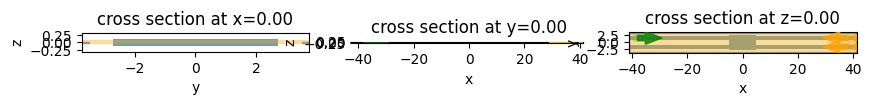

In [ ]:
import matplotlib.pyplot as plt
# starting set of input parameters
width0=5.4
length0=10

jax_sim = make_simulation(width=width0, length=length0)
_, axes = plt.subplots(1, 3, figsize=(10, 10))

# sim, _ = jax_sim.to_simulation()
for ax, dim in zip(axes, "xyz"):
    jax_sim.plot(**{dim: 0}, ax=ax)
plt.show()

## Initial Guess
To get a good initial guess for the geometry (the length) we will use the methodology introduced in the ['Intoduction to MMIs' notebook](./30_mmi_briefing.ipynb).

Effective index of computed modes:  [[1.641746  1.626001  1.5997876 1.5633625 1.5179322 1.6420181 1.6270313
  1.6019529 1.566696  1.5213424]]


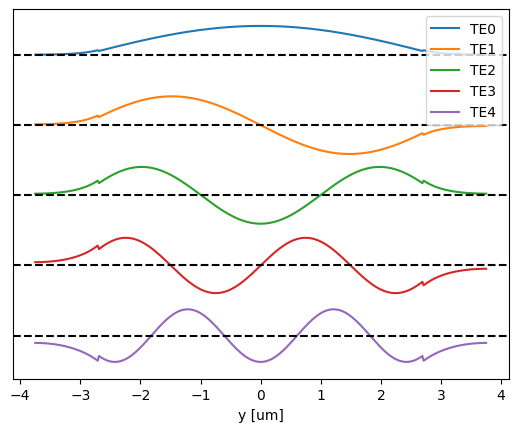

In [ ]:
from tidy3d.plugins.mode import ModeSolver
import numpy as np

num_modes = 10
mode_spec = td.ModeSpec(num_modes=num_modes, filter_pol="te")

center_plane = td.Box(center=(0,0,0), size=(0,td.inf, td.inf))
input_plane = td.Box(
    size=(0, 1.5, 1.5),
    center=(-length_sim/2+port_pad, 0.5*wg_offset, 0)
)

mode_solver = ModeSolver(
    simulation=jax_sim.to_simulation()[0], plane=center_plane, mode_spec=mode_spec, freqs=[freq0]
)
modes = mode_solver.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))


for mode_ind in range(num_modes//2):
    field = modes.field_components["Ey"].sel(mode_index=mode_ind)
    plt.plot(field.real.y, np.squeeze(field.real) - mode_ind*30, label=f"TE{mode_ind}")
    plt.axhline(-mode_ind*30, linestyle="--", color="k")

plt.xlabel("y [um]")
plt.yticks([])
if not is3D:
    plt.legend()

As seen the multimode section supports x Modes (depending on width, index contrast).

In [ ]:
d_neff = modes.n_eff.sel(mode_index=0)-modes.n_eff.sel(mode_index=1)
k0 = 2*np.pi/wavelength
l_pi = np.pi/(k0*d_neff)
l_pi = float(np.real(l_pi))

In [ ]:
length0 = l_pi*3/2
length0

73.83275413513184

Let's revalidate that the simulation for our chosen initial guess looks good

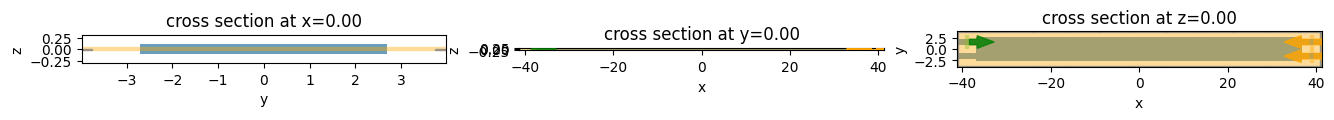

In [ ]:
jax_sim = make_simulation(width=width0, length=length0)
_, axes = plt.subplots(1, 3, figsize=(16, 20))

# sim, _ = jax_sim.to_simulation()
for ax, dim in zip(axes, "xyz"):
    jax_sim.plot(**{dim: 0}, ax=ax)
plt.show()

## Objective Function
We will have to define some objective to optimize. Here we will use the worst case transmission (of the "thru" and "drop" ports). To do so the per port objective function is defined as $0.5-P_{port}$.

In [ ]:
from tidy3d.plugins.adjoint import JaxSimulationData
from tidy3d.plugins.adjoint.web import run as run_adjoint
def compute_powers(jax_sim_data: JaxSimulationData) -> float:
    """Post process the result of the JaxSimulation run to return the power in the modes at index=0."""

    freq0 = jax_sim_data.simulation.output_monitors[0].freqs[0]

    pows = []
    for name in ["thru", "drop"]:
      jax_mode_data = jax_sim_data.output_monitor_data[name]
      mode_amps = jax_mode_data.amps
      amp = mode_amps.sel(direction="+", f=freq0, mode_index=0)
      jax.debug.print(f"{name}: |.|={{abs}} /_={{ang}}", abs=jnp.abs(amp), ang=jnp.rad2deg(jnp.angle(amp)))
      pows.append(abs(amp) ** 2)
    return pows

To optimize for the worst case we will want to minimize the maximum of those objective functions. The same idea would apply across frequencies, if we were looking for broadband behavior. To avoid "jumping" between optimizing one port's transmission while deteriorating the other, let's "smoothen" the maximum function a bit.

In [ ]:
def plot_field(sim_data):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))
    ax1 = sim_data.plot_field("field_mnt", "Ez", z=0, ax=ax1)
    ax2 = sim_data.plot_field("field_mnt", "E", "abs^2", z=0, ax=ax2)
    plt.show()

def loss_fn(x) -> float:
    """."""
    width = x[0]
    length = x[1]
    jax_sim = make_simulation(width=width, length=length)
    jax_sim_data = run_adjoint(jax_sim, task_name="adjoint_power", verbose=True)
    jax.debug.callback(plot_field, jax_sim_data)
    pows = compute_powers(jax_sim_data)
    losss = 0.5-jnp.array(pows)
    return jnp.inner(jax.nn.softmax(losss*max_weight), losss)

## Differentiation
as the loss function is fully differentiable by JAX (including the maxwell simulation) we can simply use JAX's gadient functionality:

In [ ]:
grad_fn = jax.value_and_grad(loss_fn)

In [ ]:
from tqdm.notebook import trange
from jax.example_libraries.optimizers import adam
import numpy as np

## Optimization
Let's set up an optimization:

In [ ]:
step_size = 0.01
init_fn, update_fn, params_fn = adam(step_size)

def step_fn(step, state):
    latent = params_fn(state)
    print(latent)
    loss, grads = grad_fn(latent)

    optim_state = update_fn(step, grads, state)

    return loss, optim_state

step=0
state = init_fn(jnp.array([width0, length0]))
losses = []
dims = []

and run it over some steps. For better results more steps should be performed...

  0%|          | 0/20 [00:00<?, ?it/s]

[ 5.343209 73.88902 ]


Output()

Output()

[11:47:54] status = success                                                                           ]8;id=851022;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=501387;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:47:56] loading SimulationData from simulation_data.hdf5                                           ]8;id=164188;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=547550;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

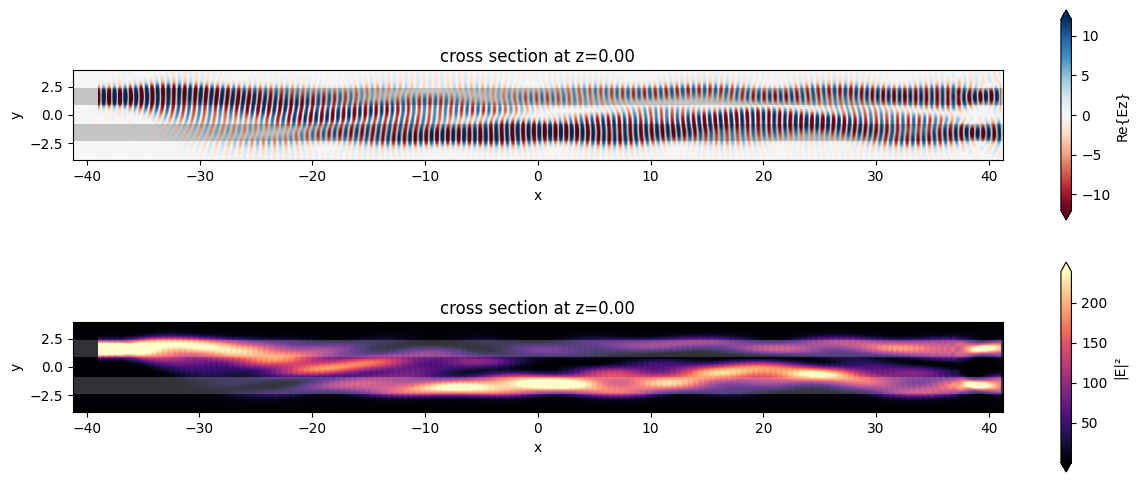

thru: |.|=0.6714630126953125 /_=82.4566421508789
drop: |.|=0.6893093585968018 /_=-5.175093173980713


Output()

Output()

[11:48:07] status = success                                                                           ]8;id=479493;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=977442;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

0.043577366
[ 5.3346734 73.89701  ]


Output()

Output()

[11:48:09] status = success                                                                           ]8;id=826431;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=639484;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:48:10] loading SimulationData from simulation_data.hdf5                                           ]8;id=532169;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=459636;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

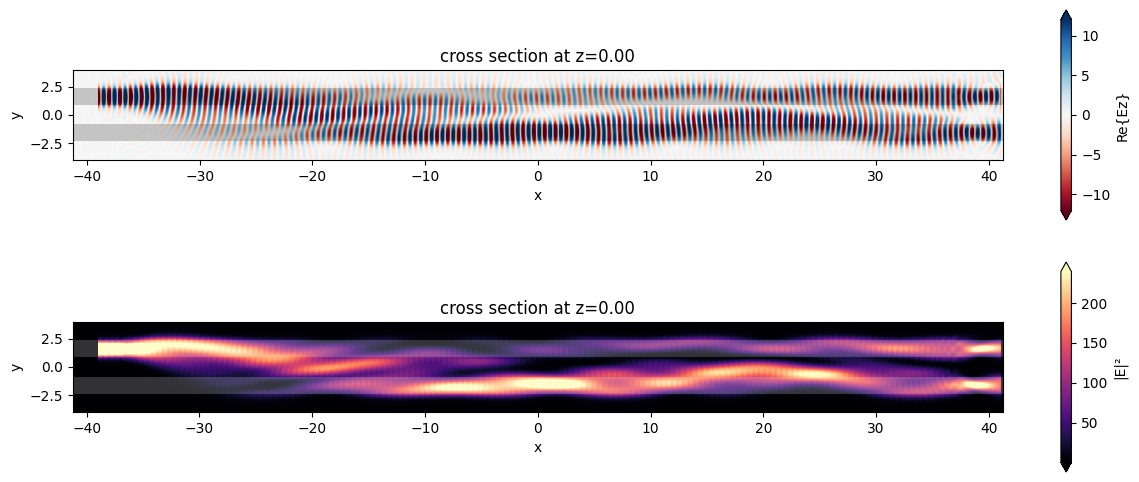

thru: |.|=0.6735112071037292 /_=80.9915771484375
drop: |.|=0.6948578357696533 /_=-6.92050313949585


Output()

Output()

[11:48:22] status = success                                                                           ]8;id=737971;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=672982;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

0.04087977
[ 5.326499 73.90453 ]


Output()

Output()

[11:48:24] status = success                                                                           ]8;id=460427;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=217137;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:48:25] loading SimulationData from simulation_data.hdf5                                           ]8;id=324857;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=699699;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

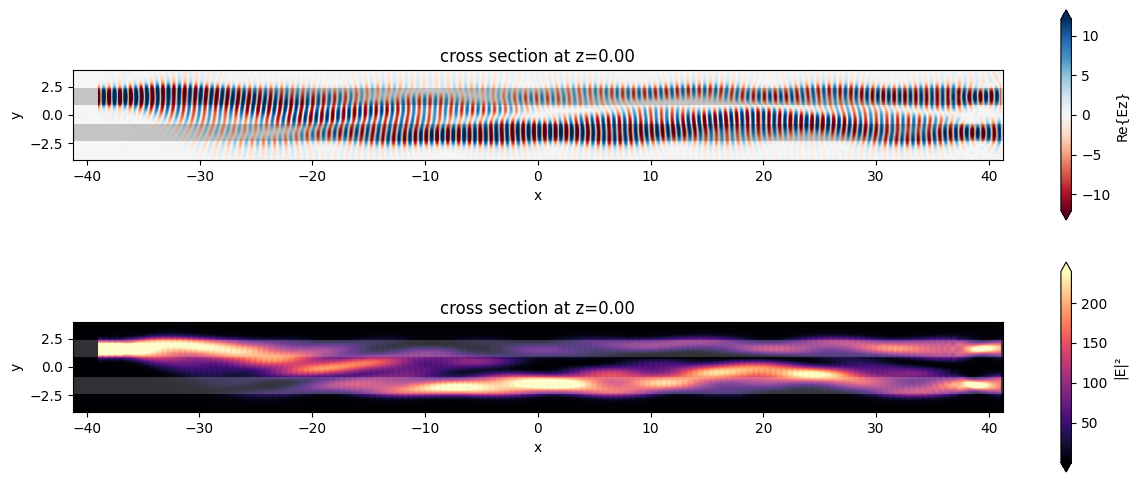

thru: |.|=0.6749585270881653 /_=79.91184997558594
drop: |.|=0.6983233690261841 /_=-8.242425918579102


Output()

Output()

[11:48:36] status = success                                                                           ]8;id=211893;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=686744;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

0.039060425
[ 5.318555 73.91167 ]


Output()

Output()

[11:48:38] status = success                                                                           ]8;id=369877;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=879626;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:48:39] loading SimulationData from simulation_data.hdf5                                           ]8;id=410640;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=677746;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

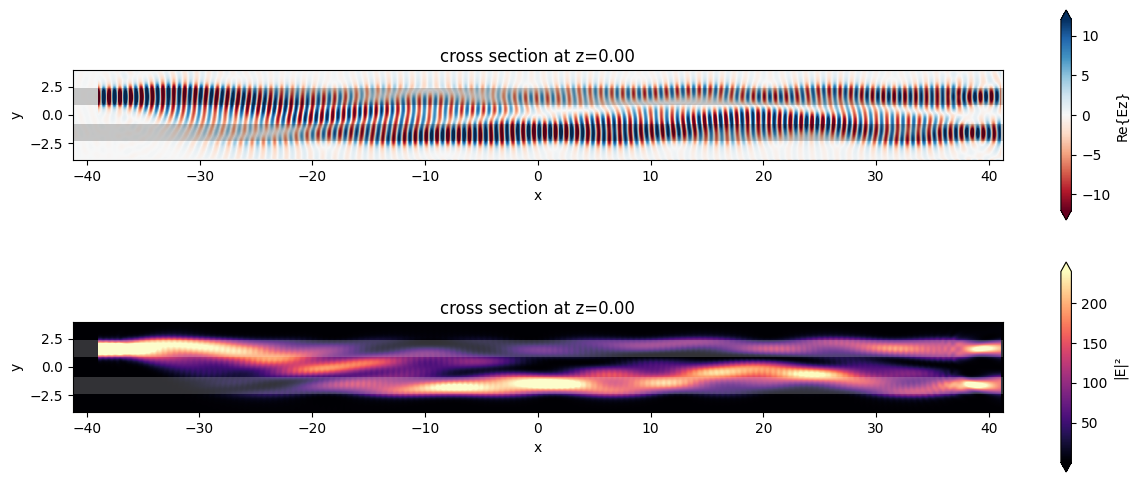

thru: |.|=0.6754379272460938 /_=79.5990219116211
drop: |.|=0.6994077563285828 /_=-8.644887924194336


Output()

Output()

[11:48:51] status = success                                                                           ]8;id=923951;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=947559;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

0.038464222
[ 5.3107715 73.918465 ]


Output()

Output()

[11:48:53] status = success                                                                           ]8;id=586914;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=490233;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:48:54] loading SimulationData from simulation_data.hdf5                                           ]8;id=945079;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=984369;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

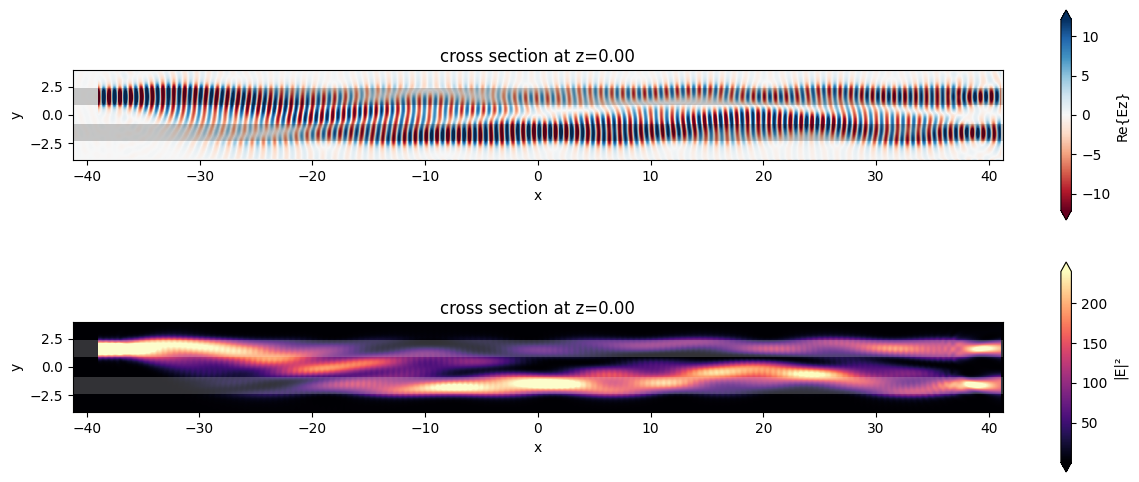

thru: |.|=0.676282525062561 /_=78.96717834472656
drop: |.|=0.7011749744415283 /_=-9.44028377532959


Output()

Output()

[11:49:08] status = success                                                                           ]8;id=498245;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=491358;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

0.037409816
[ 5.30313 73.92493]


Output()

Output()

[11:49:10] status = success                                                                           ]8;id=878561;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=69120;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:49:11] loading SimulationData from simulation_data.hdf5                                           ]8;id=184881;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=575112;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

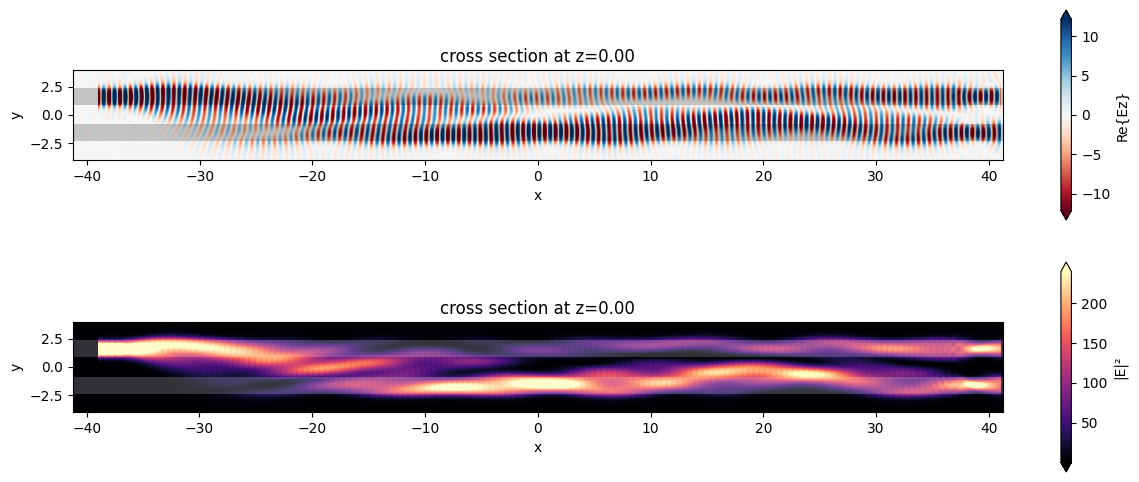

thru: |.|=0.6777359843254089 /_=77.74712371826172
drop: |.|=0.7038779854774475 /_=-10.979950904846191


Output()

Output()

[11:49:22] status = success                                                                           ]8;id=281222;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=485850;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

0.035576463
[ 5.2956395 73.93115  ]


Output()

Output()

[11:49:24] status = success                                                                           ]8;id=832348;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=320334;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:49:29] loading SimulationData from simulation_data.hdf5                                           ]8;id=111130;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=520073;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

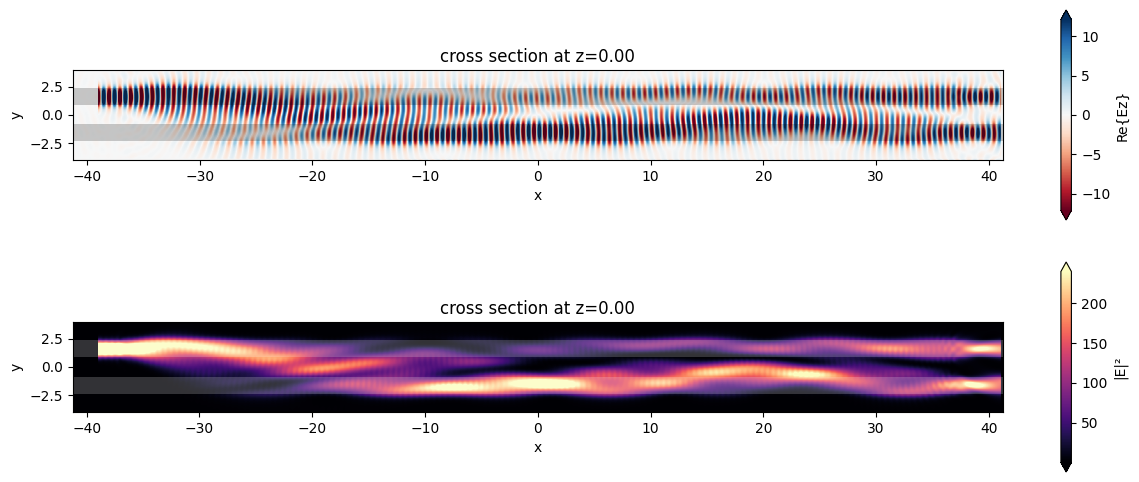

thru: |.|=0.6791608929634094 /_=76.40271759033203
drop: |.|=0.7060542702674866 /_=-12.696433067321777


Output()

Output()

[11:49:41] status = success                                                                           ]8;id=903226;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=793141;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

0.0337339
[ 5.2884173 73.937126 ]


Output()

Output()

[11:49:42] status = success                                                                           ]8;id=96718;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=94444;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:49:44] loading SimulationData from simulation_data.hdf5                                           ]8;id=956626;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=17886;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

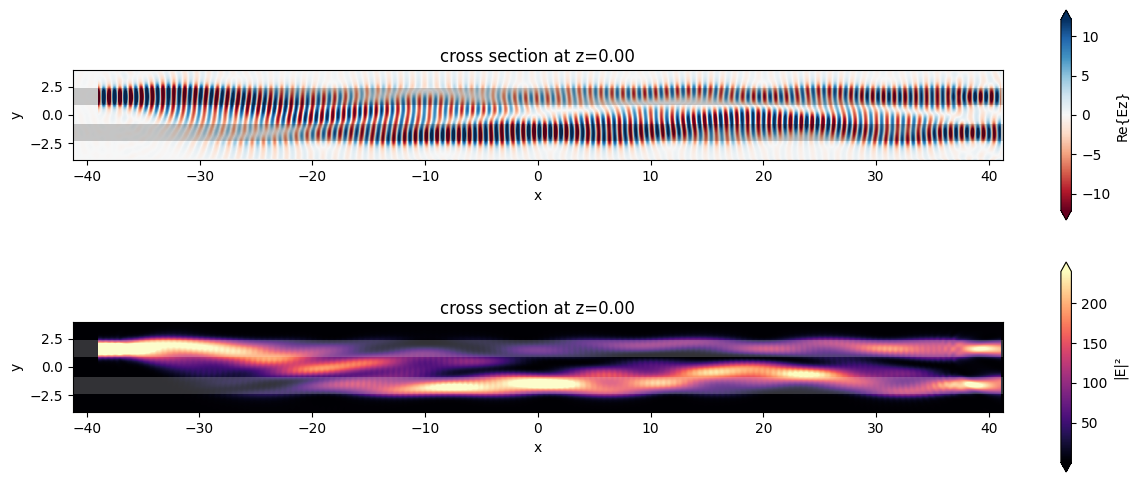

thru: |.|=0.6801576018333435 /_=75.32466888427734
drop: |.|=0.7072086334228516 /_=-14.0813627243042


Output()

Output()

[11:49:55] status = success                                                                           ]8;id=789318;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=320587;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

0.03240196
[ 5.2814083 73.94283  ]


Output()

Output()

[11:49:57] Created task 'adjoint_power' with task_id 'fdve-eaf33ba6-93b7-4600-b27a-22f31ac1a926v1'.   ]8;id=272190;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=574738;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\

           View task using web UI at                                                                  ]8;id=40406;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=402210;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=298596;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eaf33ba6-93b7-4600-b27a-22f31ac1a926v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=934225;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eaf33ba6-93b7-4600-b27a-22f31ac1a926v1\taskId]8;;\]8;id=298596;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eaf33ba6-93b7-4600-b27a-22f31ac1a926v1\=]8;;\]8;id=586032;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eaf33ba6-93b7-4600-b27a-22f31ac1a926v1\fdve]8;;\]8;id=298596;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eaf33ba6-93b7-4600-b27a-22f31ac1a926v1\-eaf33ba6-93b7-4600-b27a-22f31ac1a92]8;;\              
           ]8;id=298596;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eaf33ba6-93b7-4600-b27a-22f31ac1a926v1\6v1']8;;\.                                                                                                   

Output()

Output()

[11:49:59] status = queued                                                                            ]8;id=905672;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=976802;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:50:07] status = preprocess                                                                        ]8;id=160190;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=268589;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:50:11] Maximum FlexCredit cost: 0.035. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=480955;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=992823;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=660128;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=175083;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

           running solver                                                                             ]8;id=746420;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=692253;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:50:23] early shutoff detected, exiting.                                                           ]8;id=905136;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=952419;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=511967;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=519024;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:50:51] status = success                                                                           ]8;id=219002;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=317635;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

[11:50:54] loading SimulationData from simulation_data.hdf5                                           ]8;id=670734;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=893301;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

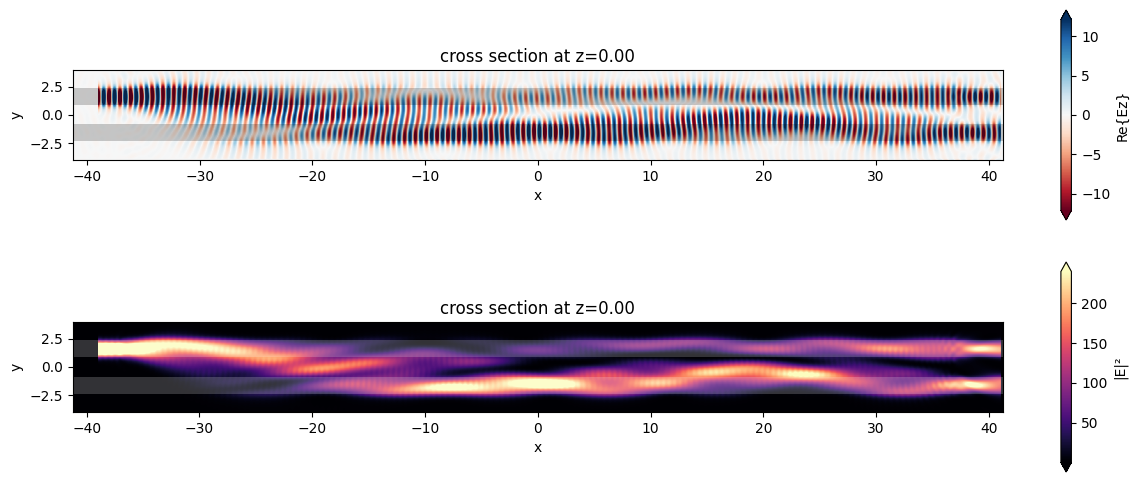

thru: |.|=0.680593729019165 /_=74.79725646972656
drop: |.|=0.7075856924057007 /_=-14.75925350189209


Output()

Output()

[11:51:05] Created task 'adjoint_power_adj' with task_id                                              ]8;id=881113;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=576978;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\
           'fdve-f0cee323-e510-4646-8f75-dfa3184a42b4v1'.                                                          

           View task using web UI at                                                                  ]8;id=348609;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=682504;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=604816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f0cee323-e510-4646-8f75-dfa3184a42b4v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=673969;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f0cee323-e510-4646-8f75-dfa3184a42b4v1\taskId]8;;\]8;id=604816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f0cee323-e510-4646-8f75-dfa3184a42b4v1\=]8;;\]8;id=719101;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f0cee323-e510-4646-8f75-dfa3184a42b4v1\fdve]8;;\]8;id=604816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f0cee323-e510-4646-8f75-dfa3184a42b4v1\-f0cee323-e510-4646-8f75-dfa3184a42b]8;;\              
           ]8;id=604816;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f0cee323-e510-4646-8f75-dfa3184a42b4v1\4v1']8;;\.                                                                                                   

Output()

Output()

[11:51:07] status = queued                                                                            ]8;id=157406;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=190754;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:51:09] status = preprocess                                                                        ]8;id=803489;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=45028;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:51:13] Maximum FlexCredit cost: 0.031. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=382544;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=503523;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=621800;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=260201;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

           running solver                                                                             ]8;id=507709;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=118996;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:51:24] early shutoff detected, exiting.                                                           ]8;id=839264;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=397506;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=303790;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=738178;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:51:31] status = success                                                                           ]8;id=604514;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=805401;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

0.031803515
[ 5.2745795 73.94831  ]


Output()

Output()

[11:51:33] Created task 'adjoint_power' with task_id 'fdve-73f78262-9598-4bf9-81b2-025f16a67634v1'.   ]8;id=634699;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=302550;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\

           View task using web UI at                                                                  ]8;id=779063;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=347248;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=247331;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73f78262-9598-4bf9-81b2-025f16a67634v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=984609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73f78262-9598-4bf9-81b2-025f16a67634v1\taskId]8;;\]8;id=247331;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73f78262-9598-4bf9-81b2-025f16a67634v1\=]8;;\]8;id=845411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73f78262-9598-4bf9-81b2-025f16a67634v1\fdve]8;;\]8;id=247331;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73f78262-9598-4bf9-81b2-025f16a67634v1\-73f78262-9598-4bf9-81b2-025f16a6763]8;;\              
           ]8;id=247331;https://tidy3d.simulation.cloud/workbench?taskId=fdve-73f78262-9598-4bf9-81b2-025f16a67634v1\4v1']8;;\.                                                                                                   

Output()

Output()

[11:51:35] status = queued                                                                            ]8;id=22757;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=349509;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:51:42] status = preprocess                                                                        ]8;id=876993;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=745980;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:51:47] Maximum FlexCredit cost: 0.035. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=753237;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=797578;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=146675;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=858213;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

           running solver                                                                             ]8;id=803468;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=458833;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:52:01] early shutoff detected, exiting.                                                           ]8;id=550127;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=904884;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=224703;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=663932;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:52:29] status = success                                                                           ]8;id=427420;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=680181;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

[11:52:31] loading SimulationData from simulation_data.hdf5                                           ]8;id=359062;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=150381;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

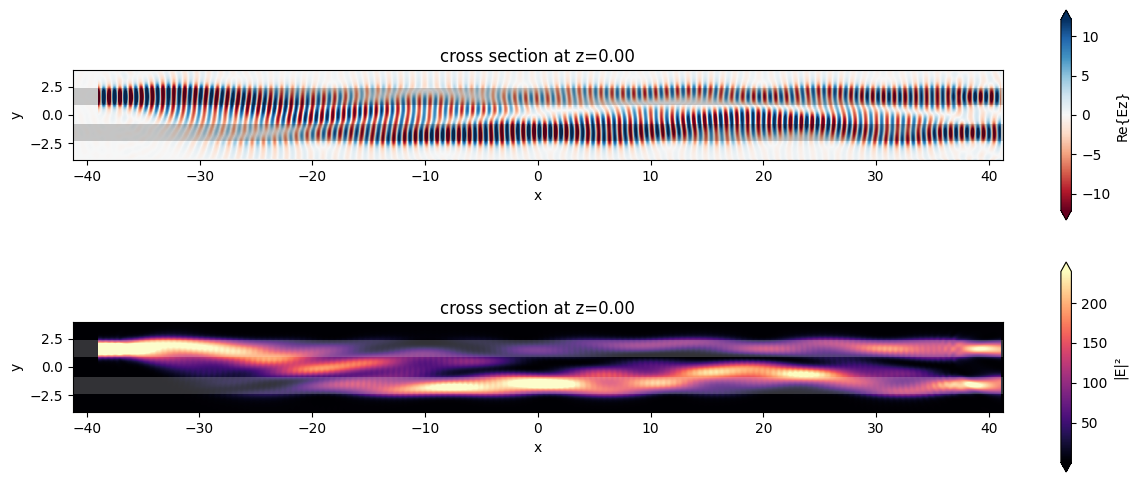

thru: |.|=0.6808004379272461 /_=74.5257797241211
drop: |.|=0.7077338695526123 /_=-15.112287521362305


Output()

Output()

[11:52:43] Created task 'adjoint_power_adj' with task_id                                              ]8;id=449285;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=182883;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\
           'fdve-36d9bb22-c62c-4368-b640-049c0493bd2dv1'.                                                          

           View task using web UI at                                                                  ]8;id=154399;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=122707;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=894731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36d9bb22-c62c-4368-b640-049c0493bd2dv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=273370;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36d9bb22-c62c-4368-b640-049c0493bd2dv1\taskId]8;;\]8;id=894731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36d9bb22-c62c-4368-b640-049c0493bd2dv1\=]8;;\]8;id=875411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36d9bb22-c62c-4368-b640-049c0493bd2dv1\fdve]8;;\]8;id=894731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36d9bb22-c62c-4368-b640-049c0493bd2dv1\-36d9bb22-c62c-4368-b640-049c0493bd2]8;;\              
           ]8;id=894731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36d9bb22-c62c-4368-b640-049c0493bd2dv1\dv1']8;;\.                                                                                                   

Output()

Output()

[11:52:44] status = queued                                                                            ]8;id=956077;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=745634;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:52:47] status = preprocess                                                                        ]8;id=684754;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=644000;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:52:54] Maximum FlexCredit cost: 0.031. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=765004;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=861242;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=355818;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=117747;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

           running solver                                                                             ]8;id=530953;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=980140;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:53:07] early shutoff detected, exiting.                                                           ]8;id=512703;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=414353;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=714548;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=631504;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:53:20] status = success                                                                           ]8;id=203988;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=148762;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

0.03151614
[ 5.267922 73.953575]


Output()

Output()

[11:53:22] Created task 'adjoint_power' with task_id 'fdve-360dd00a-c45e-4020-ad91-2303f770fc45v1'.   ]8;id=148174;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=814092;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\

           View task using web UI at                                                                  ]8;id=939776;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=420986;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=444105;https://tidy3d.simulation.cloud/workbench?taskId=fdve-360dd00a-c45e-4020-ad91-2303f770fc45v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=606740;https://tidy3d.simulation.cloud/workbench?taskId=fdve-360dd00a-c45e-4020-ad91-2303f770fc45v1\taskId]8;;\]8;id=444105;https://tidy3d.simulation.cloud/workbench?taskId=fdve-360dd00a-c45e-4020-ad91-2303f770fc45v1\=]8;;\]8;id=682393;https://tidy3d.simulation.cloud/workbench?taskId=fdve-360dd00a-c45e-4020-ad91-2303f770fc45v1\fdve]8;;\]8;id=444105;https://tidy3d.simulation.cloud/workbench?taskId=fdve-360dd00a-c45e-4020-ad91-2303f770fc45v1\-360dd00a-c45e-4020-ad91-2303f770fc4]8;;\              
           ]8;id=444105;https://tidy3d.simulation.cloud/workbench?taskId=fdve-360dd00a-c45e-4020-ad91-2303f770fc45v1\5v1']8;;\.                                                                                                   

Output()

Output()

[11:53:24] status = queued                                                                            ]8;id=112830;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=176765;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:53:27] status = preprocess                                                                        ]8;id=713827;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=934335;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:53:33] Maximum FlexCredit cost: 0.035. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=315686;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=308907;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=683014;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=836418;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

[11:53:34] running solver                                                                             ]8;id=868054;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=637919;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:53:48] early shutoff detected, exiting.                                                           ]8;id=697030;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=100665;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=422738;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=424244;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:54:26] status = success                                                                           ]8;id=96618;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=223644;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

[11:54:29] loading SimulationData from simulation_data.hdf5                                           ]8;id=580549;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=836168;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

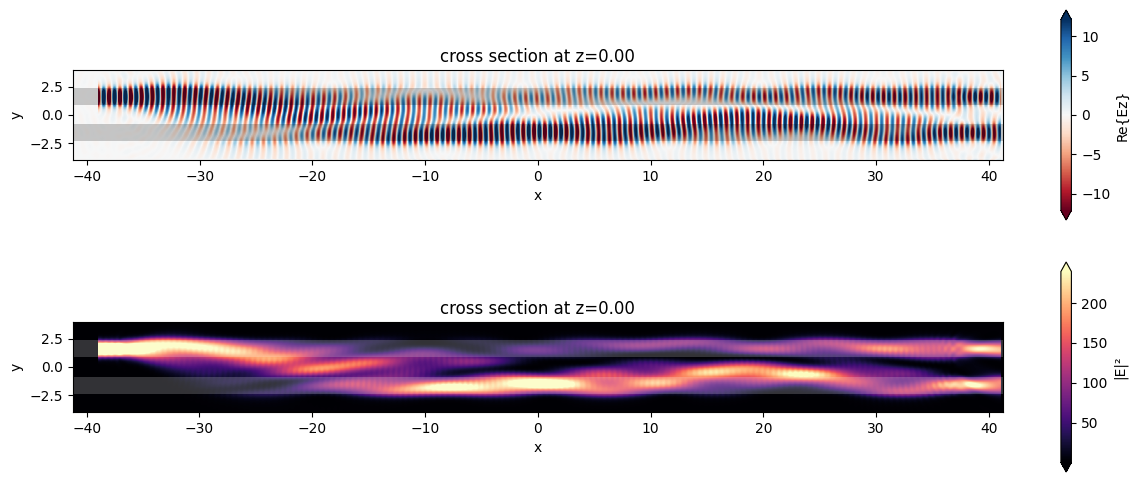

thru: |.|=0.6813574433326721 /_=73.64881896972656
drop: |.|=0.7079594731330872 /_=-16.238290786743164


Output()

Output()

[11:54:41] Created task 'adjoint_power_adj' with task_id                                              ]8;id=84197;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=177728;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\
           'fdve-4ee0133c-0dc4-4b0d-9421-466cc4765323v1'.                                                          

           View task using web UI at                                                                  ]8;id=78876;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=655646;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=15819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ee0133c-0dc4-4b0d-9421-466cc4765323v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=991439;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ee0133c-0dc4-4b0d-9421-466cc4765323v1\taskId]8;;\]8;id=15819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ee0133c-0dc4-4b0d-9421-466cc4765323v1\=]8;;\]8;id=571306;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ee0133c-0dc4-4b0d-9421-466cc4765323v1\fdve]8;;\]8;id=15819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ee0133c-0dc4-4b0d-9421-466cc4765323v1\-4ee0133c-0dc4-4b0d-9421-466cc476532]8;;\              
           ]8;id=15819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ee0133c-0dc4-4b0d-9421-466cc4765323v1\3v1']8;;\.                                                                                                   

Output()

Output()

[11:54:42] status = queued                                                                            ]8;id=416651;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=576823;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:54:49] status = preprocess                                                                        ]8;id=386042;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=795585;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:54:54] Maximum FlexCredit cost: 0.031. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=903034;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=977846;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=178376;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=273288;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

           running solver                                                                             ]8;id=821858;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=336545;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:55:06] early shutoff detected, exiting.                                                           ]8;id=546228;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=427412;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=149743;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=881864;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:55:14] status = success                                                                           ]8;id=341204;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=637970;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

0.030721372
[ 5.261475 73.95856 ]


Output()

Output()

[11:55:16] Created task 'adjoint_power' with task_id 'fdve-419636f7-0436-4a02-a2d8-cb15248c50d3v1'.   ]8;id=524581;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=245703;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\

           View task using web UI at                                                                  ]8;id=849992;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=882108;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=793504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-419636f7-0436-4a02-a2d8-cb15248c50d3v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=103979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-419636f7-0436-4a02-a2d8-cb15248c50d3v1\taskId]8;;\]8;id=793504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-419636f7-0436-4a02-a2d8-cb15248c50d3v1\=]8;;\]8;id=461478;https://tidy3d.simulation.cloud/workbench?taskId=fdve-419636f7-0436-4a02-a2d8-cb15248c50d3v1\fdve]8;;\]8;id=793504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-419636f7-0436-4a02-a2d8-cb15248c50d3v1\-419636f7-0436-4a02-a2d8-cb15248c50d]8;;\              
           ]8;id=793504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-419636f7-0436-4a02-a2d8-cb15248c50d3v1\3v1']8;;\.                                                                                                   

Output()

Output()

[11:55:18] status = queued                                                                            ]8;id=95166;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=8153;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:55:20] status = preprocess                                                                        ]8;id=183827;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=515240;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:55:24] Maximum FlexCredit cost: 0.035. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=976500;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=343627;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=864436;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=486170;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

           running solver                                                                             ]8;id=616949;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=237357;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:55:38] early shutoff detected, exiting.                                                           ]8;id=234103;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=803000;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=66361;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=960707;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:56:03] status = success                                                                           ]8;id=773570;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=964649;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

[11:56:05] loading SimulationData from simulation_data.hdf5                                           ]8;id=258277;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=244118;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

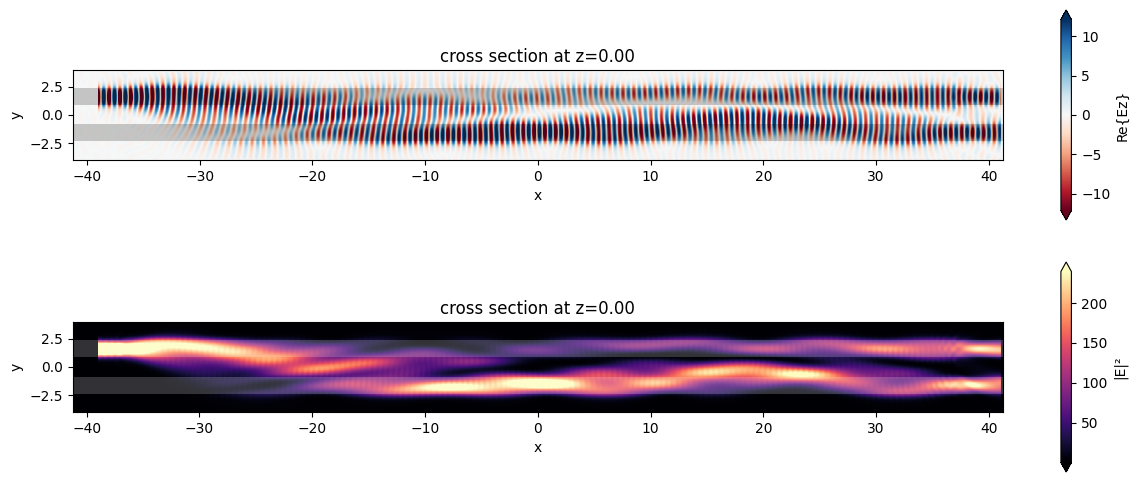

thru: |.|=0.6819174885749817 /_=72.49040985107422
drop: |.|=0.7077907919883728 /_=-17.727436065673828


Output()

Output()

[11:56:17] Created task 'adjoint_power_adj' with task_id                                              ]8;id=191651;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=623472;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\
           'fdve-d410e11b-734f-4ad2-a42d-a99fefd3f03av1'.                                                          

           View task using web UI at                                                                  ]8;id=840143;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=928648;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=327067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d410e11b-734f-4ad2-a42d-a99fefd3f03av1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=178239;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d410e11b-734f-4ad2-a42d-a99fefd3f03av1\taskId]8;;\]8;id=327067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d410e11b-734f-4ad2-a42d-a99fefd3f03av1\=]8;;\]8;id=818174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d410e11b-734f-4ad2-a42d-a99fefd3f03av1\fdve]8;;\]8;id=327067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d410e11b-734f-4ad2-a42d-a99fefd3f03av1\-d410e11b-734f-4ad2-a42d-a99fefd3f03]8;;\              
           ]8;id=327067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d410e11b-734f-4ad2-a42d-a99fefd3f03av1\av1']8;;\.                                                                                                   

Output()

Output()

[11:56:19] status = queued                                                                            ]8;id=86008;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=384343;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:56:21] status = preprocess                                                                        ]8;id=752619;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=226454;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:56:28] Maximum FlexCredit cost: 0.031. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=672112;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=265506;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=151475;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=695978;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

[11:56:29] running solver                                                                             ]8;id=507919;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=220070;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:56:42] early shutoff detected, exiting.                                                           ]8;id=10483;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=592874;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=910986;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=822055;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:56:55] status = success                                                                           ]8;id=394762;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=48318;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

0.029878546
[ 5.255311 73.96315 ]


Output()

Output()

[11:56:57] Created task 'adjoint_power' with task_id 'fdve-017c260d-879d-4ee9-a097-0e183ce1faa1v1'.   ]8;id=905637;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=960819;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\

           View task using web UI at                                                                  ]8;id=457980;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=84161;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=307760;https://tidy3d.simulation.cloud/workbench?taskId=fdve-017c260d-879d-4ee9-a097-0e183ce1faa1v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=945198;https://tidy3d.simulation.cloud/workbench?taskId=fdve-017c260d-879d-4ee9-a097-0e183ce1faa1v1\taskId]8;;\]8;id=307760;https://tidy3d.simulation.cloud/workbench?taskId=fdve-017c260d-879d-4ee9-a097-0e183ce1faa1v1\=]8;;\]8;id=871226;https://tidy3d.simulation.cloud/workbench?taskId=fdve-017c260d-879d-4ee9-a097-0e183ce1faa1v1\fdve]8;;\]8;id=307760;https://tidy3d.simulation.cloud/workbench?taskId=fdve-017c260d-879d-4ee9-a097-0e183ce1faa1v1\-017c260d-879d-4ee9-a097-0e183ce1faa]8;;\              
           ]8;id=307760;https://tidy3d.simulation.cloud/workbench?taskId=fdve-017c260d-879d-4ee9-a097-0e183ce1faa1v1\1v1']8;;\.                                                                                                   

Output()

Output()

[11:56:59] status = queued                                                                            ]8;id=651943;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=885090;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:57:08] status = preprocess                                                                        ]8;id=189186;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=298899;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:57:12] Maximum FlexCredit cost: 0.035. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=924717;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=177477;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=798961;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=966109;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

           running solver                                                                             ]8;id=685910;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=381549;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:57:24] early shutoff detected, exiting.                                                           ]8;id=613257;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=252960;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=453676;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=996572;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:57:50] status = success                                                                           ]8;id=176550;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=658485;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

[11:57:53] loading SimulationData from simulation_data.hdf5                                           ]8;id=618229;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=739207;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#583\583]8;;\

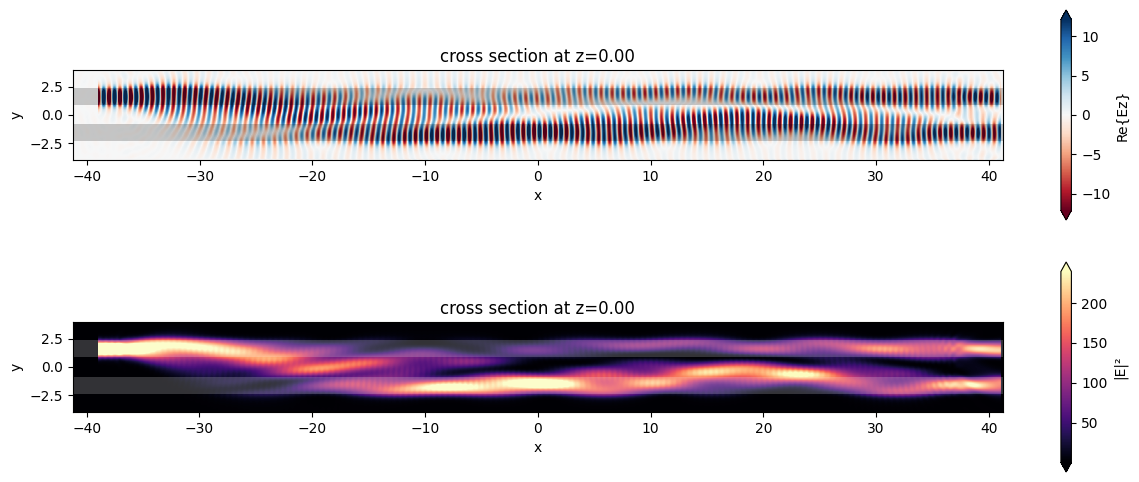

thru: |.|=0.682266891002655 /_=71.33556365966797
drop: |.|=0.7071109414100647 /_=-19.213376998901367


Output()

Output()

[11:58:04] Created task 'adjoint_power_adj' with task_id                                              ]8;id=589171;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=951273;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\
           'fdve-ba2efd69-719a-43f3-b8e2-3be1bbe01e33v1'.                                                          

           View task using web UI at                                                                  ]8;id=284072;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=941256;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=458527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba2efd69-719a-43f3-b8e2-3be1bbe01e33v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=687002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba2efd69-719a-43f3-b8e2-3be1bbe01e33v1\taskId]8;;\]8;id=458527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba2efd69-719a-43f3-b8e2-3be1bbe01e33v1\=]8;;\]8;id=56868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba2efd69-719a-43f3-b8e2-3be1bbe01e33v1\fdve]8;;\]8;id=458527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba2efd69-719a-43f3-b8e2-3be1bbe01e33v1\-ba2efd69-719a-43f3-b8e2-3be1bbe01e3]8;;\              
           ]8;id=458527;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ba2efd69-719a-43f3-b8e2-3be1bbe01e33v1\3v1']8;;\.                                                                                                   

Output()

Output()

[11:58:06] status = queued                                                                            ]8;id=616717;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=792510;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:58:08] status = preprocess                                                                        ]8;id=493849;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=502850;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:58:14] Maximum FlexCredit cost: 0.031. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=849691;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=58025;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=263950;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=114624;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

           running solver                                                                             ]8;id=820796;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=113590;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:58:26] early shutoff detected, exiting.                                                           ]8;id=809418;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=36096;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=544612;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=252152;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

[11:58:34] status = success                                                                           ]8;id=310227;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=108624;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#405\405]8;;\

Output()

0.02929577
[ 5.24956 73.96723]


Output()

Output()

[11:58:36] Created task 'adjoint_power' with task_id 'fdve-176c948a-2e07-4e94-bed4-fe969f9fa336v1'.   ]8;id=488042;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=824518;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#200\200]8;;\

           View task using web UI at                                                                  ]8;id=150598;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=233866;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#202\202]8;;\
           ]8;id=389964;https://tidy3d.simulation.cloud/workbench?taskId=fdve-176c948a-2e07-4e94-bed4-fe969f9fa336v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=240281;https://tidy3d.simulation.cloud/workbench?taskId=fdve-176c948a-2e07-4e94-bed4-fe969f9fa336v1\taskId]8;;\]8;id=389964;https://tidy3d.simulation.cloud/workbench?taskId=fdve-176c948a-2e07-4e94-bed4-fe969f9fa336v1\=]8;;\]8;id=131216;https://tidy3d.simulation.cloud/workbench?taskId=fdve-176c948a-2e07-4e94-bed4-fe969f9fa336v1\fdve]8;;\]8;id=389964;https://tidy3d.simulation.cloud/workbench?taskId=fdve-176c948a-2e07-4e94-bed4-fe969f9fa336v1\-176c948a-2e07-4e94-bed4-fe969f9fa33]8;;\              
           ]8;id=389964;https://tidy3d.simulation.cloud/workbench?taskId=fdve-176c948a-2e07-4e94-bed4-fe969f9fa336v1\6v1']8;;\.                                                                                                   

Output()

Output()

[11:58:37] status = queued                                                                            ]8;id=733762;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=84574;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#336\336]8;;\

Output()

[11:58:40] status = preprocess                                                                        ]8;id=930268;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=336305;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#330\330]8;;\

[11:58:47] Maximum FlexCredit cost: 0.035. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=394091;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=449533;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#353\353]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=487034;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=738977;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#357\357]8;;\

           running solver                                                                             ]8;id=209482;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=645633;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#367\367]8;;\

Output()

[11:59:02] early shutoff detected, exiting.                                                           ]8;id=972853;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=828752;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#381\381]8;;\

           status = postprocess                                                                       ]8;id=860941;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=299613;file:///usr/local/lib/python3.10/dist-packages/tidy3d/web/webapi.py#398\398]8;;\

Output()

KeyboardInterrupt: ignored

In [ ]:
#|eval:false
Nsteps=20
range_ = trange(step, step+Nsteps)
max_weight = 50 
for step in range_:
    if step >= 13:
      max_weight = 100 #let's put a stronger emphasis on balanced output after some steps
    loss, state = step_fn(step, state)
    print(loss)
    losses.append(loss)
    dims.append(params_fn(state))
    range_.set_postfix(loss=float(loss))

In [ ]:
#| hide
print(losses)
print(dims)

[Array(0.06669489, dtype=float32), Array(0.06228521, dtype=float32), Array(0.05488141, dtype=float32), Array(0.04975458, dtype=float32), Array(0.04773521, dtype=float32), Array(0.0464123, dtype=float32), Array(0.04357737, dtype=float32), Array(0.04087977, dtype=float32), Array(0.03906043, dtype=float32), Array(0.03846422, dtype=float32), Array(0.03740982, dtype=float32), Array(0.03557646, dtype=float32), Array(0.0337339, dtype=float32), Array(0.03240196, dtype=float32), Array(0.03180351, dtype=float32), Array(0.03151614, dtype=float32), Array(0.03072137, dtype=float32), Array(0.02987855, dtype=float32), Array(0.02929577, dtype=float32)]
[Array([ 5.3900003, 73.84276  ], dtype=float32), Array([ 5.3800445, 73.85276  ], dtype=float32), Array([ 5.3703184, 73.86252  ], dtype=float32), Array([ 5.361025, 73.8718  ], dtype=float32), Array([ 5.352005, 73.880585], dtype=float32), Array([ 5.343209, 73.88902 ], dtype=float32), Array([ 5.3346734, 73.89701  ], dtype=float32), Array([ 5.326499, 73.904

[<matplotlib.lines.Line2D>]

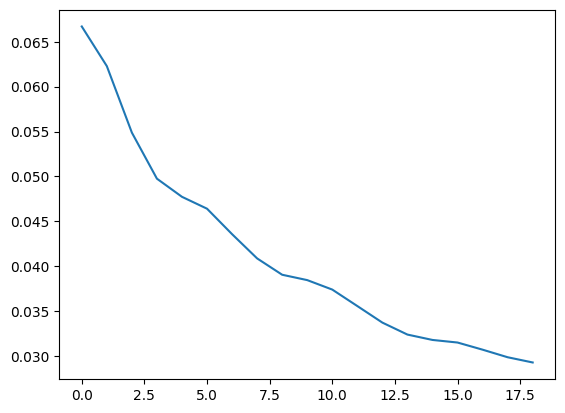

In [ ]:
plt.plot(losses)